# Speech enhancement by Wiener filtering - Voice activity detection and all pole modelling of the vocal tract
*Laurent Colbois, Lionel Desarzens  
COM-415 Audio and Acoustic Signal Processing course  
EPFL 2018-2019*

***Abstract***

# 1. Introduction

## 2. Review of existing techniques (How thorough ?)

## 3. Algorithm description

We denote $y$ the noisy speech signal to enhance. $y$ is decomposed between a clean speech signal $s$ and a noise signal $n$, i.e. $y = s + n$. The denoising algorithm is supposed to build a good estimate $\hat{s}$ of $s$. In practice, we build artificially $y$ by adding noise of our choice (either white noise, or noise from another sound file) to a clean speech sample. This allows in particular to control freely the SNR of $y$. The algorithm we use for speech enhancement is called *Iterative Wiener Filtering* and is presented hereafter.

### 3.1 Wiener filtering
The general approach for the denoising process is by the use of a Wiener filter that we apply in the STFT domain.
The main principle of a Wiener filter is the following : given an input signal $x$ and a target signal $d$, the Wiener filter is a linear filter that, when applied on $x[n]$, gives as an output $\hat{d}$ such that the error $e[n] = \hat{d} - d$ is minimized in the least square sense. In the context of speech enhanchement, the input signal is $y = s + n$, and the target signal would be $s$. Note that in general $s$ is not actually known; however if one gains some insight on the spectral properties of $s$, a reasonable Wiener filter can be constructed.

According to **Cite main article** or **Cite Loizou book**, in the context of speech enhancement a good Wiener filter, given in the frequency domain, is 
$$H(\omega) = \frac{P_s(\omega)}{P_s(\omega)+P_n(\omega)}$$  
where $P_s$ and $P_n$ are the power spectral density (PSD) of respectively the speech and the noise. The main focus of this work is to build a good estimation of those PSDs.  

The general approach we choose to build those estimations consists in the following steps. 
> 0. Split the signal in analysis frames (possibly overlapping)
> 1. Run the signal through a voice activity detection module (VAD), identify each frame as either speech or noise
> 2. If processing a noise frame : compute a noise PSD estimation
> 3. If processing a speech frame :  
    4.1 Read the noise PSD estimation from previous noise frames  
    4.2 Compute the speech PSD estimation  
    4.3 Apply the denoising procedure (build and apply the Wiener filter)-> obtain estimate $\hat{s}$ of $s$  
    4.4 Optional : compute a noise PSD estimation for the current frame by considering the residual  $y - \hat{s}$, that can possibly be considered when filtering future frames 
    
The detail of how the implementation of the VAD algorithm, the noise PSD estimation and the speech PSD estimation are given in the following subsections.

### 3.2 Voice Activity Detection (VAD)
The VAD is an algorithm used in speech processing. It main purpose is (as said above) to classify a frame as containing speech, or not. Many different kind of VAD exist (see [], [] and []), but as the VAD is not the main objective of this project, we used the one defined in [] (see github... for the implementation).

#### 3.2.1 Estimating noise floor level [...]
This VAD works using the average noise level. For each frame, the signal energy level is computed :

$$L^{(n)} = \sqrt{\frac{1}{K} \sum_{k=0}^{K-1} \left(W_k \cdot \left \lvert Y_{k}^{(n)} \right \rvert \right )^2}$$

where $W_k$ is a weigthing function, and $Y_k^{(n)}$ is the DFT of the $n$-th frame on K points. The aim of using a weighting function is to give more importance to the frequency where noise and signal are very different. <br>
    As most of the energy of the noise is contained in the low part of the spectrum, using a high-pass filter might be a good idea. Moreover most of the speech energy is contained between $125 Hz$ and $300 Hz$.

#### 3.2.2. Dual-Constant time integrator
For this method, the estimate of the noise floor level at $n$-th frame can be computed as follow :

$$L_{min}^{(n)} = \begin{cases} \left (1-\frac{T}{\tau_{up}} \right )L_{min}^{(n-1)}+\frac{T}{\tau_{up}}L^{n}, & L^{(n)}>L_{min}^{(n-1)} \\ 
\left (1-\frac{T}{\tau_{down}} \right )L_{min}^{(n-1)}+\frac{T}{\tau_{down}}L^{n}, & L^{(n)}\leq L_{min}^{(n-1)} \end{cases}$$

where $T$ is the frame duration, $\tau_{up}$ and $\tau_{down}$ are the time constant to track the noise.

#### 3.2.3. Decision
Finally, using the estimated noise floor level, and the signal energy level, the decision of the VAD can be expressed as follow :
$$V^{(n)} = \begin{cases} 0 & \mbox{if} \frac{L^{(n)}}{L_{min}^{(n)}}<T_{down} \\ 
1 & \mbox{if} \frac{L^{(n)}}{L_{min}^{(n)}}>T_{up} \\
V^{(n-1)} & \mbox{otherwise}\end{cases}$$

#### 3.2.4 Further implementation
It has been shown in [???] that the previous explained method works well on high SNR values. In some case, it might be interesting to implement a second type of VAD which is more robust to low SNR. Such algorithms are called Statistical VAD.

As the aime of this project was to reduce noise, we did not implement this king of VAD.

### 3.3 Noise PSD estimation
All computations are done under the assumption that the noise is white centered gaussian with variance $\sigma_n^2$. In this case we simply have $P_n(\omega) = \sigma_n^2$.

**Update rule for $\sigma$'s**

### 3.4 Speech PSD estimation : all-pole model
The estimation of the speech PSD relies on modelling the speech production as an auto-regressive model. **Cite Lim, Oppenheim**. More specifically, the speech signal $s$ is written as 
$$ s[l] = \sum\limits_{k=1}^{p} a_k s[l-k] + g\cdot w[l] $$  
where $g$ is a gain factor, and $w[l]$ is a simple excitation. $p$ is a chosen parameter. For voiced speech, w[l] is modeled as a simple periodic excitation, while it is modeled as white noise for unvoiced speech. This is also equivalent to say the vocal tract acts on the initial exictation as the following transfer function :

$$ V(\omega) = \frac{g}{1- \sum\limits_{k=1}^{p} a_k e^{-jk\omega}} $$ In this case the estimated speech PSD is
$$ P_s(\omega) = \frac{g^2}{\left| 1- \sum\limits_{k=1}^{p} a_k e^{-jk\omega} \right|^2}$$


The computation of the coefficient vector $\mathbf{a}$ is done by LPC analysis **Cite Atal, Hanauer**. The gain factor $g^2$ by an energy consideration : the total power of the signal should be the sum of the speech power and the noise power. This is rewritten as the condition that, once $\mathbf{a}$ has been computed, $g^2$ should be chosen such that
$$\int_{-\pi}^{\pi} P_s(\omega) \text{d}\omega = \sum\limits_{k=0}^{N-1}y^2[k] - N\sigma_n^2$$

One obvious issue is that the noisy signal can not in general be well approximated by the auto-regressive model, as it does not consist of speech only. An iterative procedure can however be used to deal with this issue. It works as follows :
> 1. Set $\hat{s}_0 := y$  
> 2. Then, for $i = 0...i_{max}-1$ :  
    > 2.1 Compute $\hat{a}_i$ and $\hat{g}_i^2$ from the signal $\hat{s}_{i}$, by the methods presented above  
    > 2.2 Compute the PSD estimate $P_{\hat{s}_i}(\omega)$ and use it to build the Wiener filter $H_i(\omega)$  
    > 2.3 Obtain $\hat{s}_{i+1}$ by filtering $y$ with $H_i(\omega)$  
    > 2.4 Go back to 2.1 for the next value of $i$  
> 3. Return $\hat{s}_{i_{max}}$ as the estimate of the denoised speech

## Results and discussion

### Evaluation metrics  
An obvious qualitative way of evaluating the performance of a speech enhancement system is simply to listen to the signal before and after the denoising operation. However we would like to also have a quantitative measure of the efficiency of the algorithm. We choose the two following metrics :

> - A posteriori SNR : from the original signal $y$ and speech signal estimation $\hat{s}$, one can build an estimate $\hat{n} = y - \hat{s}$ of the noise signal. This allows to compute the SNR of $\hat{s}$ with respect to $\hat{n}$, and to compare it with the true SNR of $s$ with respect to $n$. This SNR a posteriori should be higher than the true SNR if the denoising operation is successful.    


> - Intelligibility : even when it increases the SNR, the denoising operation might add some distortion in the speech signal and decrease its intelligibility. In order to get a quantitative measure of intelligibilty, we use a pretrained neural network for classification of speech signal (Google Speech Command Dataset). This network is asked to classify speech signals at various SNR ratios, and we compare its classification certainty for noisy speech and denoised speech. The code for this operation was greatly inspired from [1].



### First experiment : sentence denoising
We will show the effectiveness of the denoising operation, both with and without VAD, on a noisy sentence at SNR of 10,20 and 30 dB. For this experiment we have no quantitative way of assessing the intelligibility of the resulting signal, but we will consider the SNR a posteriori, as well as the subjective qualitative measure of intelligibility one can get by simply listening to the denoised signal. Remark : the STFT is always performed with a 50% overlap, and cosine analysis and synthesis windows.

In [1]:
import speech as sp
import IPython

speech_file = '../samples/speech_male/arctic_a0001.wav'
noise_file = '../samples/noise/crowd.wav' # Leave empty for adding generated white noise instead
snr_vals = [10]
p = 10 #Order of the all pole filter
frame_size = 400 # Window size for the STFT
iterations = 5 # Number of iterations to compute the Wiener Filter
alpha = 0.05 # Parameter of the sigma update in the VAD

#Initialize outputs
s = [None]*len(snr_vals)
s_VAD = [None]*len(snr_vals)
voice_activity = [None]*len(snr_vals)
sigma_tracking = [None]*len(snr_vals)
# Load the clean speech sample
y_clean, sr = sp.data.load(speech_file)

for i,SNR in enumerate(snr_vals):
    print('SNR = {}'.format(SNR))
    # Add noise to the speech, at requested SNR
    if(noise_file == ''):
        y = sp.data.add_white_noise(y_clean,SNR)
    else:
        y = sp.data.add_noise_from_file(y_clean,sr,'../samples/noise/crowd.wav',SNR)
    # Denoising only
    print('    Denoising...')
    s[i] = sp.process.denoise(y,frame_size,p,iterations)
    # VAD + Denoising
    print('    Denoising with VAD...')
    s_VAD[i],voice_activity[i],sigma_tracking[i] = sp.process.denoise_with_vad(y,sr,frame_size,p,iterations,alpha)


print('Done!')

SNR = 10
    Denoising...
    Denoising with VAD...
Done!


In [24]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
def plot_signal(signal):
    fig,(ax0,ax1) = plt.subplots(nrows = 1, ncols=2,figsize=(16,4))
    t = np.arange(len(signal))/sr
    
    ax0.plot(t,signal)
    ax0.set_xlabel('Time[s]')
    ax0.set_ylabel('Normalized amplitude')
    ax0.set_title('Signal')
    _,_,_,cax = ax1.specgram(signal,NFFT=frame_size,Fs = sr)
    ax1.set_xlabel('Time[s]')
    ax1.set_ylabel('Frequency [Hz]')
    ax1.set_title('Spectrogram')
    cbar = plt.colorbar(cax)
    cbar.set_label('Amplitude [dB]')
    IPython.display.display(IPython.display.Audio(signal,rate=sr))

def plot_SNR(s):    
    time_SNR = sp.evaluate.time_SNR(y,s,frame_size)
    t = np.arange(len(s))/sr
    true_SNR = sp.evaluate.time_SNR(y,y_clean,200)
    post_SNR = sp.evaluate.time_SNR(y,s,200)

    fig = plt.figure(figsize=(6,4))
    plt.plot(true_SNR,label='True SNR')
    plt.plot(post_SNR,label='A posteriori SNR')
    plt.xlabel('Time [s]')
    plt.ylabel('SNR [dB]')
    plt.legend()
    return fig

def plot_VAD(voice_activity,sigma_tracking):
    fig,(ax0,ax1) = plt.subplots(nrows = 1, ncols = 2,figsize=(16,4))
    ax0.plot(voice_activity)
    ax0.set_xlabel('Frame')
    ax0.set_ylabel('Noise (0) or speech (1)')
    ax0.set_title('Voice activity')
    
    ax1.plot(sigma_tracking)
    ax1.set_xlabel('Frame')
    ax1.set_ylabel('$\sigma_n$')
    ax1.set_title('Noise estimation')
    
    return fig

The following figures present the sound file, the time signal and the spectrogram for respectively :
> 1. The input noisy signal
> 2. The signal obtained by simple denoising
> 3. The signal obtained by VAD + denoising
> 4. The actual clean signal

SNR = 10 dB, noisy signal


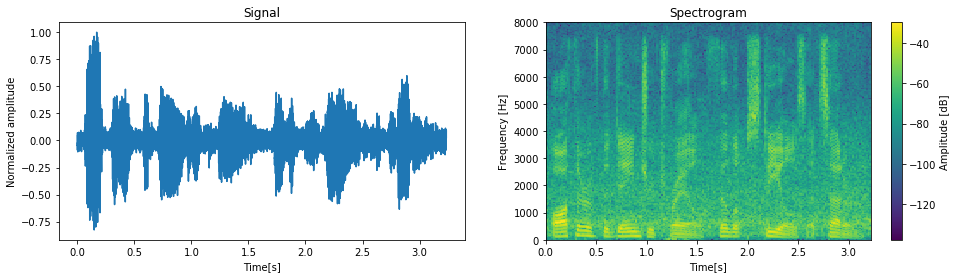

In [10]:
print('SNR = 10 dB, noisy signal')
plot_signal(y)

SNR = 10 dB, no VAD


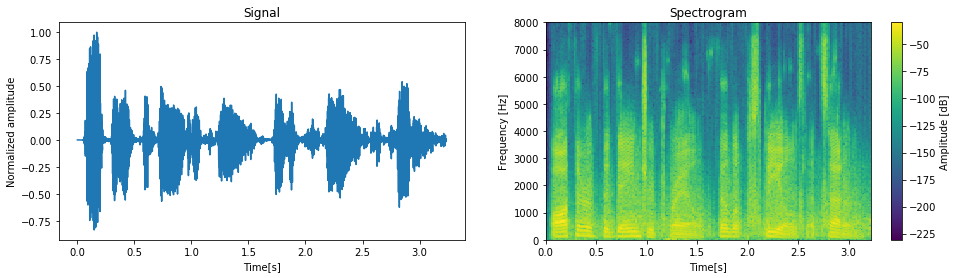

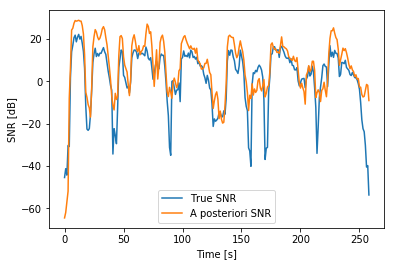

In [20]:
print('SNR = 10 dB, no VAD')
display_results(s[0])
snr_fig = plot_SNR(s[0])

SNR = 10 dB, VAD


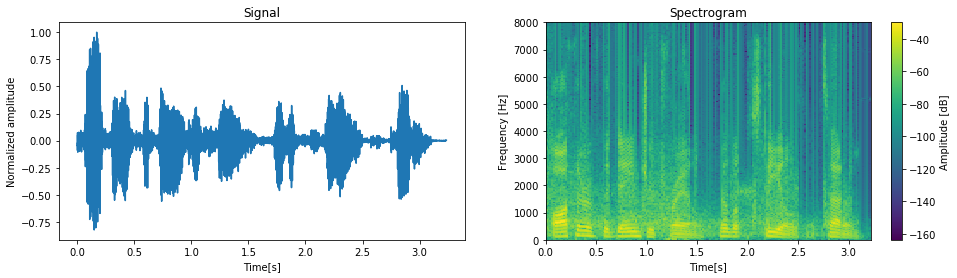

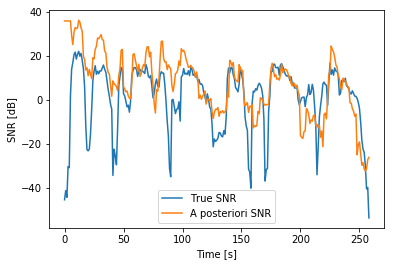

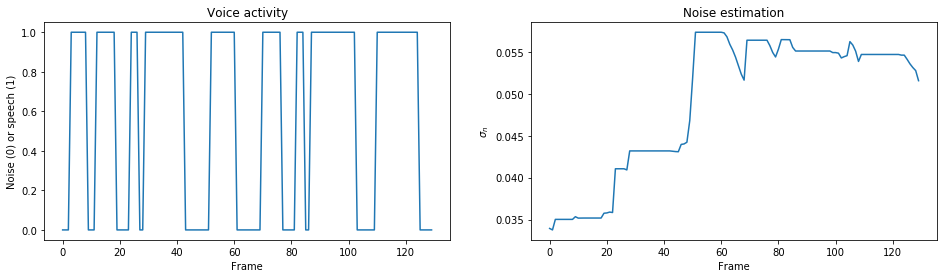

In [25]:
print('SNR = 10 dB, VAD')
display_results(s_VAD[0])
snr_fig = plot_SNR(s_VAD[0])
vad_fig = plot_VAD(voice_activity[0],sigma_tracking[0])

SNR = 10 dB, exact clean signal


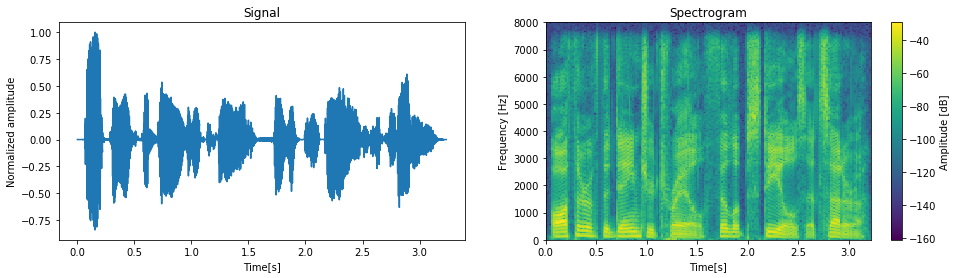

In [26]:
print('SNR = 10 dB, exact clean signal')
display_results(y_clean)

### Phrase denoising
We start by studying qualitatively the effectiveness on

## Conclusion

## Bibliography

<html>

<head>
<title>evaluation</title>
<meta http-equiv="content-type" content="text/html; charset=UTF-8">
<meta name="generator" content="bibtex2html">
</head>

<body>

<!-- This document was automatically generated with bibtex2html 1.98
     (see http://www.lri.fr/~filliatr/bibtex2html/),
     with the following command:
     /usr/bin/bibtex2html evaluation.bib  -->


<table>

<tr valign="top">
<td align="right" class="bibtexnumber">
[<a name="Mermet:255834">1</a>]
</td>
<td class="bibtexitem">
Alexis Mermet.
 Augmenting "pyroomacoustics" with machine learning utilities.
 2018.
 SEMESTER_PROJECT.
[<a href="http://infoscience.epfl.ch/record/255834">http</a>&nbsp;]

<tr valign="top">
<td align="right" class="bibtexnumber">
[<a name="Mermet:255834">2</a>]
</td>
<td class="bibtexitem">
    Michael Grimm and Kristian Kroschel
    Robust Speech Recognition and Understanding,
    ISBN 987-3-90213-08-0, pp.460, I-Tech, Vienna, Austria, June 2007
    
<tr valign="top">
<td align="right" class="bibtexnumber">
[<a name="Mermet:255834">3</a>]
</td>
<td class="bibtexitem">
Md Sahidullah, Student Member, IEEE, Goutam Saha, Member, IEEE
    Comparison of Speech Activity Detection Techniques for Speaker Recognition,
    October 2006
    
<tr valign="top">
<td align="right" class="bibtexnumber">
[<a name="Mermet:255834">4</a>]
</td>
<td class="bibtexitem">
Jongseo Sohn, Student Member, IEEE, Nam Soo Kim, Member, IEEE, and Wonyong Sung
    A Statistical Model-Based Voice Activity Detection, 
    IEEE SIGNAL PROCESSING LETTERS, VOL. 6, NO. 1, JANUARY 1999 
    
<tr valign="top">
<td align="right" class="bibtexnumber">
[<a name="Mermet:255834">5</a>]
</td>
<td class="bibtexitem">
Ivan J. Tashev
    Sound Capture and Processing: Practical Approaches, 
    2009 John Wiley & Sons, Ltd. ISBN: 978-0-470-31983-3 
    
    
    

</td>
</tr>
</table><hr><p><em>This file was generated by
<a href="http://www.lri.fr/~filliatr/bibtex2html/">bibtex2html</a> 1.98.</em></p>
</body>
</html>


In [3]:
%%bash 
python evaluate_single_sample.py

Dataset exists! Using ./google_speech_commands
Dataset exists! Using ./google_speech_commands
Dataset exists! Using ./google_speech_commands
Dataset exists! Using ./google_speech_commands
speech file info :
Metadata:
    word : go
    speech : True
    file_loc : ./google_speech_commands/go/b1f8326d_nohash_1.wav
noise file info:
Metadata:
    word : NA
    noise_type : white_noise
    speech : False
    file_loc : ./google_speech_commands/_background_noise_/white_noise.wav

SNR : 100.000000 dB
go (score = 0.95390)
down (score = 0.01680)
no (score = 0.01402)
go (score = 0.94809)
no (score = 0.01818)
_unknown_ (score = 0.01692)
go (score = 0.94732)
no (score = 0.01822)
_unknown_ (score = 0.01746)

SNR : 95.000000 dB
go (score = 0.95467)
down (score = 0.01652)
no (score = 0.01474)
go (score = 0.94901)
no (score = 0.01806)
_unknown_ (score = 0.01626)
go (score = 0.94814)
no (score = 0.01819)
_unknown_ (score = 0.01670)

SNR : 90.000000 dB
go (score = 0.95639)
down (score = 0.01673)
no (sco

/home/lcolbois/anaconda3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
Instructions for updating:
Use tf.gfile.GFile.
